In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
from numba import jit

In [2]:
def generate_policy(prob_dist, max_period):
    num_choices = 2
    
    probs = prob_dist[:,0]
    weights = prob_dist[:,1]
    num_probs = len(probs)

    max_streak = max_period
    num_states = max_streak + 1

    ## Get array of choices and possible states
    max_streaks = np.arange(0, num_states)
    streaks = np.arange(0, num_states)
    choices = np.arange(0, num_choices)
    probs_plus_1 = np.concatenate((probs , np.array([1])))

    ## Calculate matrices
    choices_mat, streaks_mat, max_streaks_mat, probs_mat = np.meshgrid(choices, streaks, max_streaks, probs)

    ##### Current Streak Updating
    ## If choice is to skip, then states are just the same as what they were
    streaks_stay_mat = streaks_mat[:, 0, :, :]

    ## If choice is to take the risk, then potential state update is current streak increases by 1
    streaks_win_mat = np.minimum(streaks_mat[:, 1, :, :] + 1, max_period)

    ## The risk though is current streak goes to zero
    streaks_lose_mat = np.zeros((num_states, num_states, num_probs), dtype='int')


    ###### Max streak Updating
    ## If choice is to skip, then states are just the same as what they were
    max_of_max_current = np.maximum(max_streaks_mat[:, 0, :, :], streaks_mat[:, 0, :, :])
    max_streaks_stay_mat = max_of_max_current
    max_streaks_lose_mat = max_of_max_current

    ## If choice is to take the risk, then potential state update is increased if current streak == max streak
    max_of_max_winstreak = np.maximum(max_streaks_mat[:, 1, :, :], streaks_mat[:, 1, :, :] + 1)
    max_streaks_win_mat = np.minimum(max_of_max_winstreak , max_period)


    #### Probs updating
    probs_new_mat = np.tile(range(0, num_probs), (num_states, num_states, 1))

    V_funcs = {}
    G_funcs = {}

    V_funcs['V' + str(max_period)] = max_of_max_current

    for period in range(max_period-1, -1, -1):
        next = period + 1
        next_V = V_funcs['V' + str(next)]

        Exp_V_stay = np.average(next_V[streaks_stay_mat, max_streaks_stay_mat, probs_new_mat], axis=2, weights = weights)
        Exp_V_win = np.average(next_V[streaks_win_mat, max_streaks_win_mat, probs_new_mat], axis=2, weights = weights)
        Exp_V_lose = np.average(next_V[streaks_lose_mat, max_streaks_lose_mat, probs_new_mat], axis=2, weights = weights)

        Exp = np.zeros((num_states, num_choices, num_states, num_probs))
        Exp[:, 0, :, :] = np.tile(Exp_V_stay, (num_probs, 1, 1)).transpose([1, 2, 0])
        Exp[:, 1, :, :] = (
            np.einsum("ij,k->ijk", Exp_V_win, probs_mat[0, 1, 0, :]) + 
            np.einsum("ij,k->ijk", Exp_V_lose, (1 - probs_mat[0, 1, 0, :]))
        )

        G_funcs['G' + str(period)] = np.array(np.argmax(Exp, axis=1), dtype=float)
        G_funcs['G' + str(period)][next:, :, :] = np.nan
        G_funcs['G' + str(period)][:, next:, :] = np.nan
        V_funcs['V' + str(period)] = np.array(np.amax(Exp, axis=1), dtype=float)
        V_funcs['V' + str(period)][next:, :] = np.nan
        V_funcs['V' + str(period)][:, next:, :] = np.nan
      
    return V_funcs, G_funcs

In [3]:
processed = Path('../data/processed')
selection_data = pd.read_pickle(Path(processed) / 'selection_data.pkl')

In [4]:
prep_data = selection_data[(selection_data.year >= 1960) & (selection_data.year <= 1999)]
selection_data = selection_data.loc[selection_data.year >= 2000]

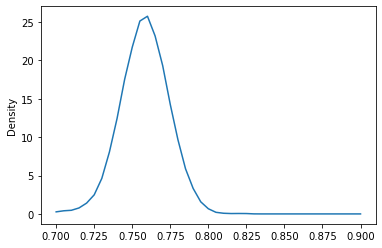

In [5]:
g_step = .005
ax = prep_data['EstProb'].plot.density(ind=np.arange(.7, .9, g_step))
prob_dist = ax.get_lines()[0].get_xydata()

In [6]:
max_periods = selection_data.groupby('year')['BAT_ID'].count().reset_index()
max_periods.columns = ['year', 'max_periods']

m_list = max_periods['max_periods'].unique()
max_m = m_list.max()

V, G = generate_policy(prob_dist, max_m)

In [7]:
num_years = len(max_periods)
results = np.zeros((num_years, 2))
    
counter = 0
for year in range(2000, 2021):
    m = max_periods[max_periods.year==year].iat[0, 1]
    dif = max_m-m
    
    test = selection_data.loc[selection_data.year == year, ['EstProb', 'Win']]
    test = test.sort_values(['Date'])
    test['Period'] = np.arange(len(test)) + 1

    test['Period'] = test.groupby(['Date'])['Period'].transform('min')
    test['Day'] = test.groupby(['Date']).ngroup()
    test = test.reset_index()

    max_day = test.Day.max()

    streak = 0
    max_streak = 0

    for day in range(0, max_day):
        temp = test.loc[test.Day == day].copy()  
        cutoff = min(prob_dist[G['G' + str(day + dif)][streak, max_streak, :].astype(bool), 0]) - .01

        if cutoff < min(prob_dist[:,0]):
            cutoff = 0
            
#         cutoff = 0

        temp['Play'] = (temp['EstProb'] > cutoff)*1

        temp['WinPlay'] = temp['Win'] * temp['Play']
        temp['LosePlay'] = (1 - temp['Win']) * temp['Play']
        total_win = temp['WinPlay'].sum()
        total_loss = temp['LosePlay'].sum()

        if total_loss > 0 :
            streak = 0
        else:
            streak = streak + total_win

        if streak > max_streak:
            max_streak = streak
        else:
            pass
        

    results[counter, 0] = year
    results[counter, 1] = max_streak
    counter = counter + 1
    print(year, ":", max_streak)

2000 : 18
2001 : 12
2002 : 23
2003 : 26
2004 : 21
2005 : 21
2006 : 15
2007 : 23
2008 : 17
2009 : 17
2010 : 14
2011 : 15
2012 : 13
2013 : 16
2014 : 12
2015 : 19
2016 : 10
2017 : 24
2018 : 26
2019 : 12
2020 : 15


In [8]:
results.sum(axis=0)

array([42210.,   369.])

In [9]:
 20 + 14 + 21 + 26 + 22 + 17 + 17 + 29 + 19 + 22 + 14 + 13 + 14 + 14 + 28 + 20 + 15 + 18 + 28 + 14 + 12

397

In [10]:
20 + 14 + 20 + 16 + 21 + 16 + 16 + 23 + 19 + 21 + 14 + 12 + 13 + 15 + 15 + 19 + 14 + 17 + 22 + 18 + 20

365

In [11]:
(397 - 388)/20

0.45

In [12]:
# updating prior distribution
# generate value functions ahead of time and save them all for easy reference
# weighted averaging instead of repeated probabilities in mesh grid
# calculate for 370 and then just adjust for seasons with fewer game days by starting after 0 on later days for shorter seasons

In [13]:
# prob_dist = np.array([[.5, 1], [.75, 1], [1, 1]])
# Yalt, Galt = generate_policy(prob_dist, 3)
# Galt['G2'][1, :, :]